### Explainability

In [81]:
import numpy as np
import pandas as pd

np.random.seed(0)

from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split
from xgboost import XGBClassifier

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [82]:
# Fetch blended credit data
url = (
    "https://drive.google.com/file/d/1LZ7K32OcocobL4jAeeVTC0O4rm0BsT-z/view?usp=sharing"
)
file_id = url.split("/")[-2]
dataset = pd.read_csv(f"https://drive.google.com/uc?id={file_id}")

In [83]:
X = dataset.copy()
y = X.pop("is_bad")

ix_train, ix_test = train_test_split(X.index, stratify=y, test_size=0.2, random_state=0)

In [84]:
xgb_model = XGBClassifier(n_estimators=500, max_depth=5, random_state=0)
xgb_model.fit(X.loc[ix_train], y.loc[ix_train])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [85]:
cv_score = (
    cross_val_score(
        xgb_model, X.loc[ix_train], y.loc[ix_train], cv=5, scoring="roc_auc"
    ).mean()
    * 2
    - 1
)

print(f"Gini CV: {cv_score:.2%}")

Gini CV: 84.77%


<h4>SHAP</h4>

In [86]:
import shap

shap.initjs()

In [87]:
explainer = shap.Explainer(xgb_model, X.loc[ix_test])
shap_values = explainer(X.loc[ix_test])

[21:16:45] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 99%|===================| 3961/4000 [00:35<00:00]        

<h5>Global Bar Plot</h5>

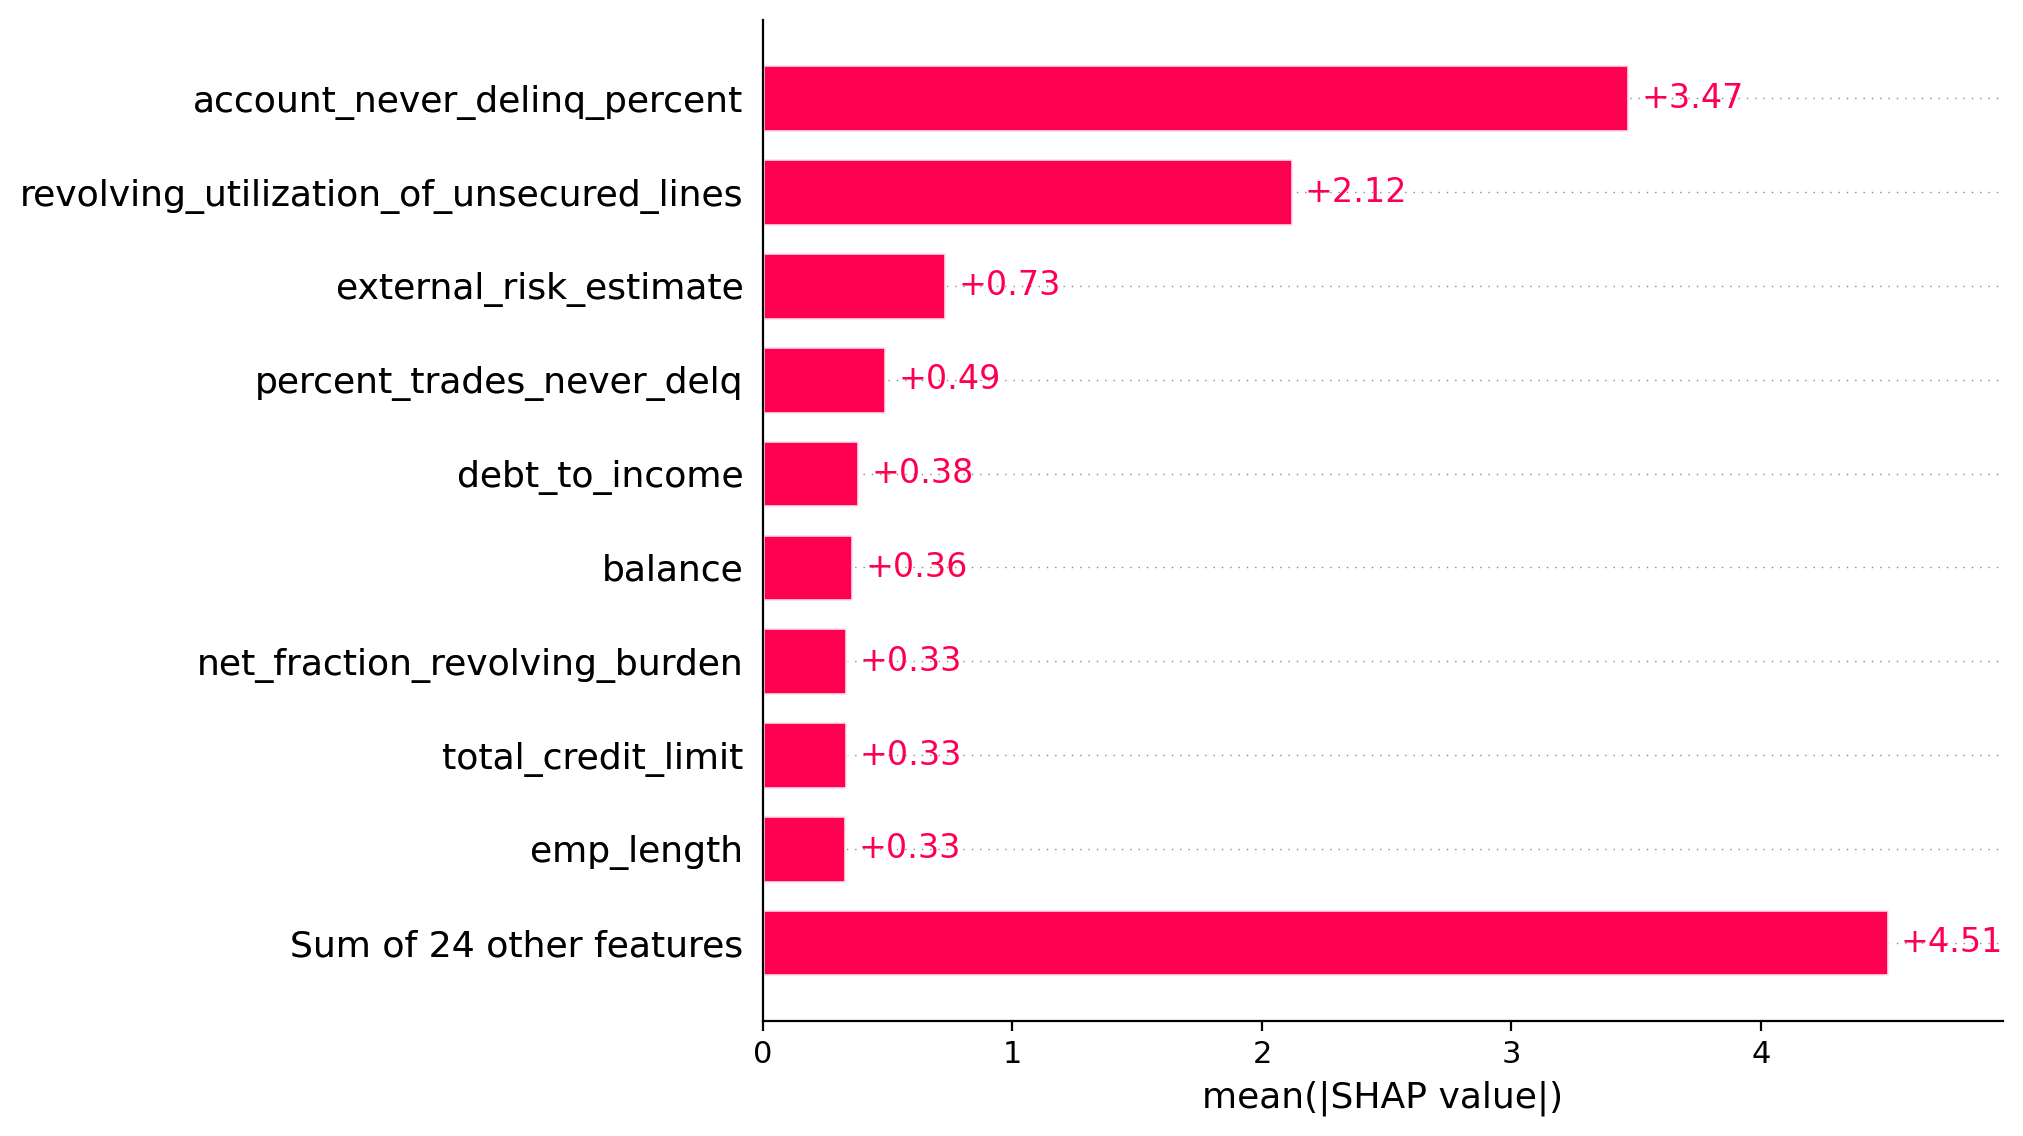

<Figure size 2000x600 with 0 Axes>

In [88]:
# global importance
fig = plt.figure()
shap.plots.bar(shap_values, max_display=10)
plt.gcf().set_size_inches(20, 6)
plt.show()

<code style="font-family: Karma, sans-serif; background:#a7fe01;color:black">We can see that most predictive features are absence of delinquencies, utilization of credit lines, and external score.</code>


<h5>Local Bar Plot</h5>

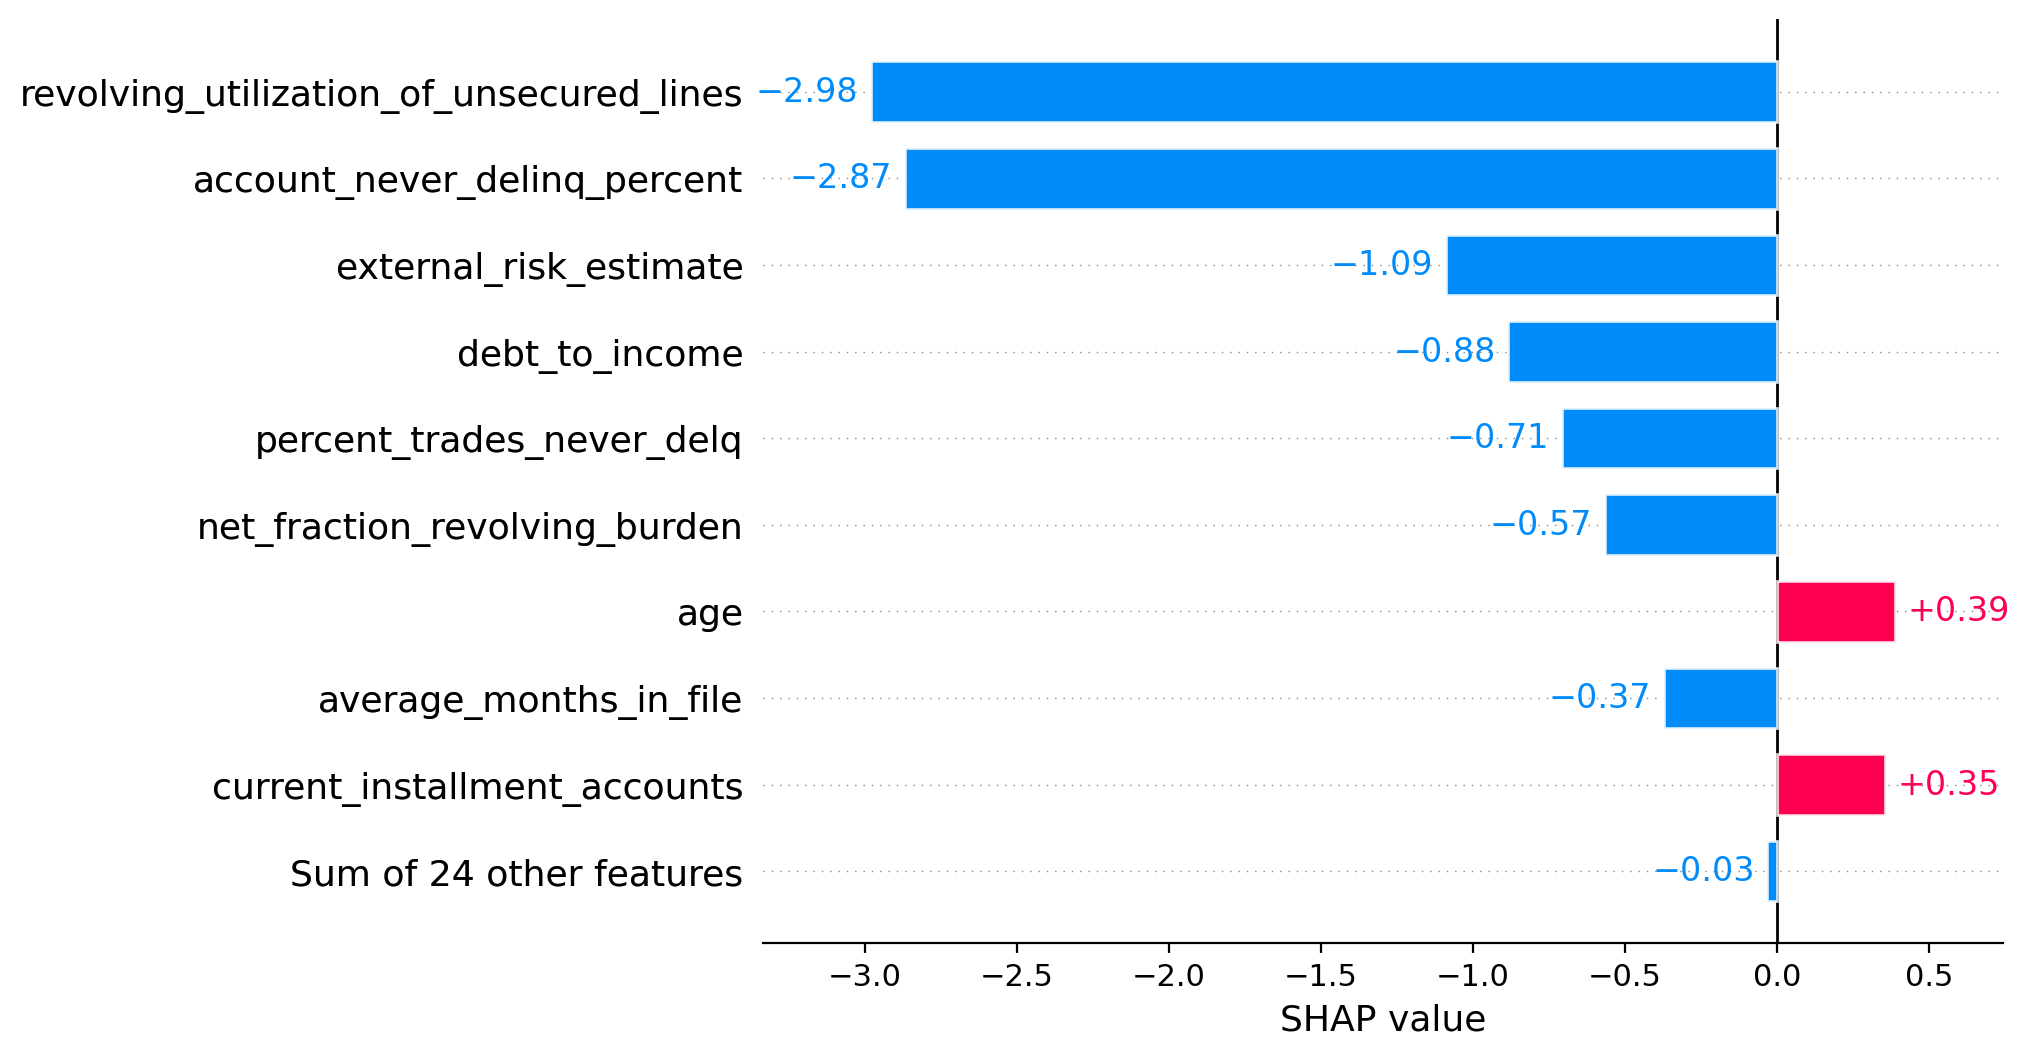

In [89]:
# local importance
fig = plt.figure()
shap.plots.bar(shap_values[1], show=False)
plt.gcf().set_size_inches(8, 6)
plt.show()

<code style="font-family: Karma, sans-serif; background:#a7fe01;color:black">Here we can see which factors decrease probability of default (in blue) and which ones increase (in red).</code>

<h5> Subplots</h5>

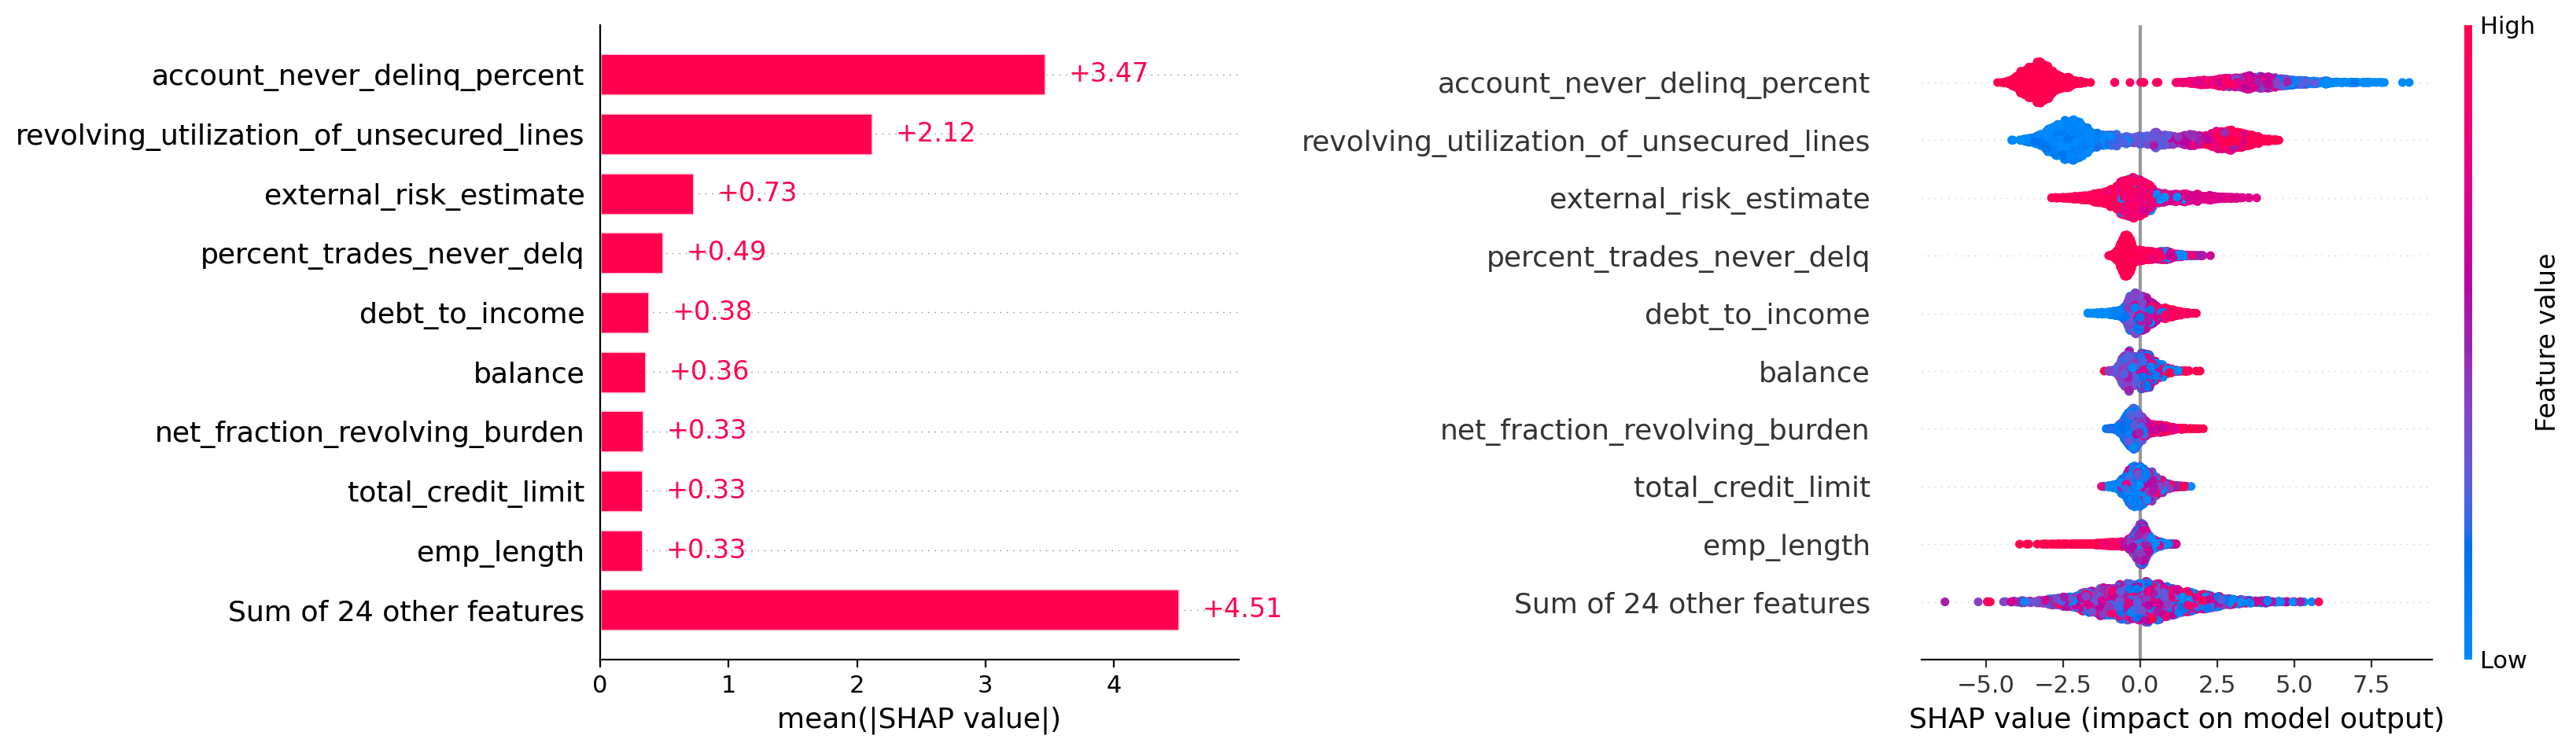

In [90]:
fig = plt.figure()
ax0 = fig.add_subplot(131)
shap.plots.bar(shap_values, show=False)
ax1 = fig.add_subplot(132)
shap.plots.beeswarm(shap_values, show=False)
plt.gcf().set_size_inches(25, 5)
plt.tight_layout()
plt.show()

<code style="font-family: Karma, sans-serif; background:#a7fe01;color:black">We can also create subplots with SHAP subplots with Matplotlib.</code>

<h5>Partial Dependence</code>

<div class="alert alert-block alert-info">
Partial dependence plots (PDP) show the dependence between the target response and a set of input features of interest, marginalizing over the values of all other input features.</div>


In [91]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=600)
ax.set_ylim(0, 0.18)
shap.plots.partial_dependence(
    "age",
    xgb_model.predict,
    X.loc[ix_test],
    ice=False,
    feature_expected_value=True,
    ax=ax,
)

<code style="font-family: Karma, sans-serif; background:#a7fe01;color:black">Here we see a non-monotonic relationship that the model learned, which makes sense because younger people and elderly can be considered risky, whereas middle-age customers are least risky.</code>


In [92]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=600)
ax.set_ylim(0, 0.18)
shap.plots.partial_dependence(
    "revolving_utilization_of_unsecured_lines",
    xgb_model.predict,
    X.loc[ix_test],
    ice=False,
    feature_expected_value=True,
    ax=ax,
)

<code style="font-family: Karma, sans-serif; background:#a7fe01;color:black">Higher levels of utilization of credit lines are linked with higher probability of default, which is intuitive (high utilization may correspond to financial difficulties).</code>


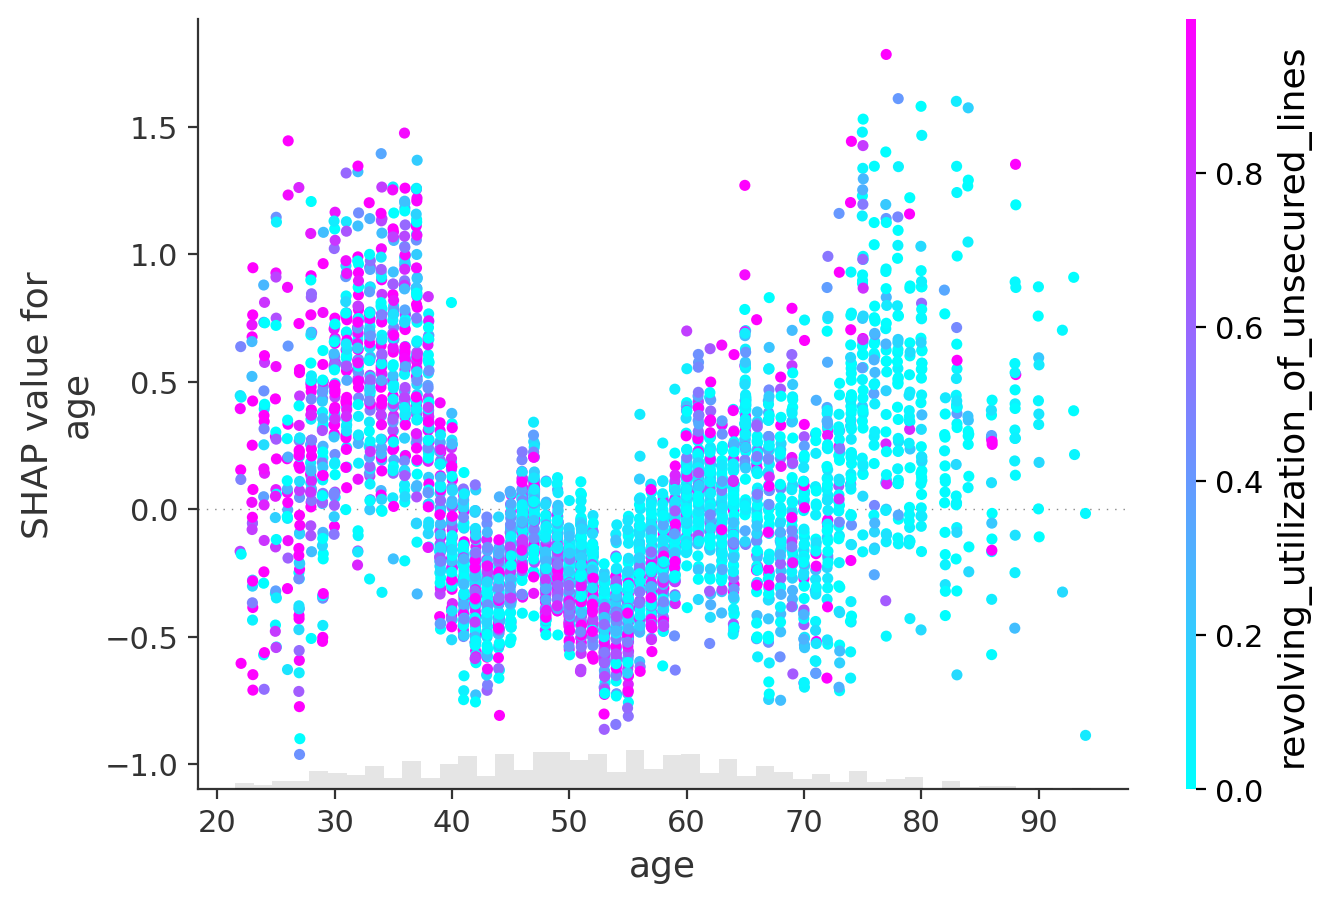

In [93]:
shap.plots.scatter(
    shap_values[:, "age"],
    shap_values[:, "revolving_utilization_of_unsecured_lines"],
    cmap=plt.get_cmap("cool"),
    hist=True,
)

In [99]:
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(figsize=(16, 6), dpi=600)
pdp_display = PartialDependenceDisplay.from_estimator(
    xgb_model,
    X.loc[ix_test],
    [
        "age",
        "revolving_utilization_of_unsecured_lines",
        ("age", "revolving_utilization_of_unsecured_lines"),
    ],
    ax=ax,
    response_method="predict_proba",
)

<code style="font-family: Karma, sans-serif; background:#a7fe01;color:black">We can see from the plots that people from younger spender groups tend to utilize their credit cards more heavily than people with middle age.</code>


<h4>Extra: TabNet Explainability</h4>

<div class="alert alert-block alert-info">
In this example, we train a TabNet model with two steps and provide explanations using SHAP and a local TabNet method.</div>

In [100]:
from pytorch_tabnet.tab_model import TabNetClassifier

tab_clf = TabNetClassifier(gamma=2.0, n_steps=2)

tab_clf.fit(
    X.loc[ix_train].to_numpy(),
    y.loc[ix_train].to_numpy().squeeze(),
    patience=5,
    max_epochs=100,
    eval_set=[
        (X.loc[ix_train].to_numpy(), y.loc[ix_train].to_numpy().squeeze()),
        (X.loc[ix_test].to_numpy(), y.loc[ix_test].to_numpy().squeeze()),
    ],
    eval_name=["train", "valid"],
    eval_metric=["auc"],
)

# evaluate performance
y_pred = tab_clf.predict_proba(X.loc[ix_test].to_numpy())
gini_score = roc_auc_score(y.loc[ix_test], y_pred[:, 1]) * 2 - 1
print(f"Gini score: {gini_score:.2%}")

Device used : cpu


epoch 0  | loss: 0.36245 | train_auc: 0.46035 | valid_auc: 0.50389 |  0:00:01s
epoch 1  | loss: 0.3014  | train_auc: 0.4205  | valid_auc: 0.43553 |  0:00:02s
epoch 2  | loss: 0.27534 | train_auc: 0.45451 | valid_auc: 0.47782 |  0:00:03s
epoch 3  | loss: 0.25198 | train_auc: 0.52185 | valid_auc: 0.52231 |  0:00:04s
epoch 4  | loss: 0.23078 | train_auc: 0.68654 | valid_auc: 0.67836 |  0:00:05s
epoch 5  | loss: 0.21837 | train_auc: 0.72696 | valid_auc: 0.71738 |  0:00:06s
epoch 6  | loss: 0.21094 | train_auc: 0.72199 | valid_auc: 0.72203 |  0:00:07s
epoch 7  | loss: 0.20332 | train_auc: 0.69769 | valid_auc: 0.68805 |  0:00:08s
epoch 8  | loss: 0.20727 | train_auc: 0.73279 | valid_auc: 0.7171  |  0:00:10s
epoch 9  | loss: 0.20234 | train_auc: 0.75108 | valid_auc: 0.74626 |  0:00:11s
epoch 10 | loss: 0.20042 | train_auc: 0.74958 | valid_auc: 0.73867 |  0:00:12s
epoch 11 | loss: 0.19595 | train_auc: 0.72366 | valid_auc: 0.70579 |  0:00:13s
epoch 12 | loss: 0.19813 | train_auc: 0.75017 | vali

Best weights from best epoch are automatically used!


Gini score: 81.54%


  0%|          | 0/100 [00:00<?, ?it/s]Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.422e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=8.994e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=7.109e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=7.109e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Early sto

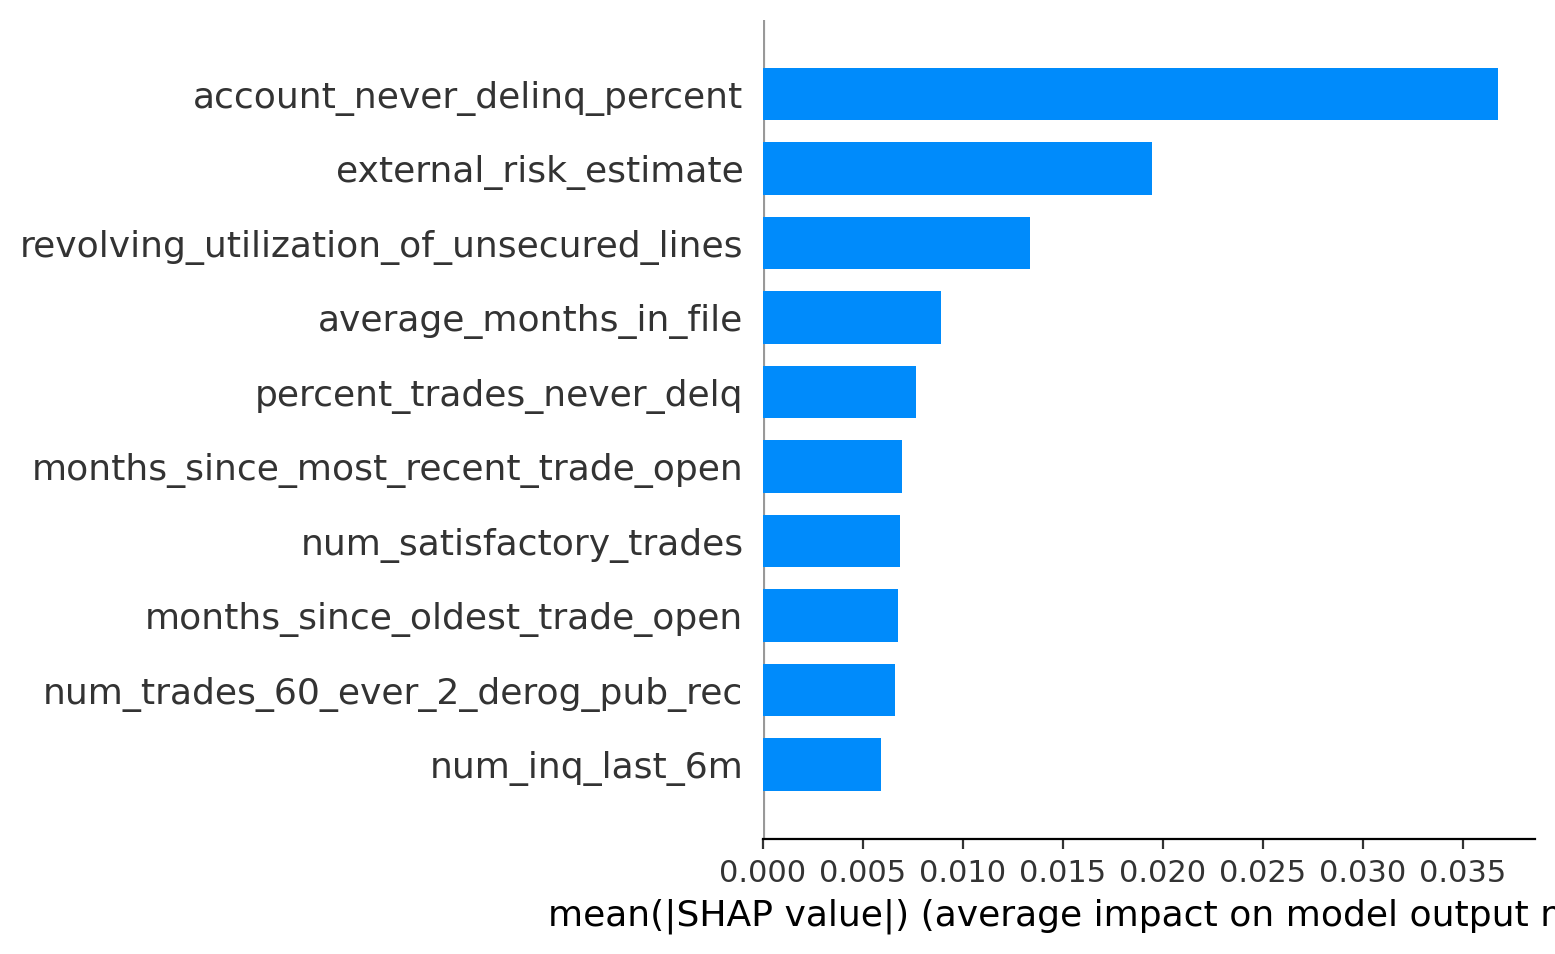

In [101]:
explainer = shap.KernelExplainer(
    tab_clf.predict_proba, X.loc[ix_test][0:100].to_numpy()
)

shap_values = explainer.shap_values(X.loc[ix_test][0:100], nsamples=20)

# global importance
shap.summary_plot(
    shap_values[1],
    X.loc[ix_test][0:100],
    plot_type="bar",
    max_display=10,
    plot_size=(8, 5),
    show=False,
)
plt.show()

In [102]:
plt.rcParams.update({"font.size": 14})

# Generating local explanations
explain_matrix, masks = tab_clf.explain(X.loc[ix_test].to_numpy())

# Plotting the TabNet feature selection masks
fig, axs = plt.subplots(1, 2, figsize=(25, 20), dpi=200)
for i in range(2):
    axs[i].imshow(masks[i][:50], cmap="cubehelix")
    x_positions = np.arange(0, len(masks[i][0]), 1.0)
    axs[i].set_xticks(x_positions)
    axs[i].set_xticklabels(X.columns, rotation=90, fontsize=10)
    axs[i].set_title(f"mask {i}")

<code style="font-family: Karma, sans-serif; background:#a7fe01;color:black">
What you see here are features the model selects based on each sample. The second layer in the model builds its predictions around utilization of credit cards thus informing decision-making.</code>